<a href="https://colab.research.google.com/github/pankajr141/experiments/blob/master/Reasoning/GAN/GAN_101_Mnist.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Objective
This is the first working notebook to train GAN on a simple task

### Task
MNIST Digit generation, build and train a GAN that can generate hand-written images of digits (0-9).

### Reference
https://github.com/sahilkhose/Generative-Adversarial-Networks-GANs-Specialization/blob/main/course1/week1/C1W1_Your_First_GAN.ipynb

## Generator

Generator class. It will take 3 values:

    The noise vector dimension
    The image dimension
    The initial hidden dimension

Using these values, the generator will build a neural network with 5 layers/blocks. Beginning with the noise vector, the generator will apply non-linear transformations via the block function until the tensor is mapped to the size of the image to be outputted (the same size as the real images from MNIST). The final layer does not need a normalization or activation function, but does need to be scaled with a sigmoid function.

In [1]:
import torch
from torch import nn
class Generator(nn.Module):
    '''
    Generator Class
    Values:
        z_dim: the dimension of the noise vector, a scalar
        im_dim: the dimension of the images, fitted for the dataset used, a scalar
          (MNIST images are 28 x 28 = 784 so that is your default)
        hidden_dim: the inner dimension, a scalar
    '''
    def __init__(self, z_dim=10, im_dim=784, hidden_dim=128):
        super(Generator, self).__init__()

        self.gen = nn.Sequential(
            self.get_generator_block(z_dim, hidden_dim),
            self.get_generator_block(hidden_dim, hidden_dim * 2),
            self.get_generator_block(hidden_dim * 2, hidden_dim * 4),
            self.get_generator_block(hidden_dim * 4, hidden_dim * 8),
            nn.Linear(hidden_dim * 8, im_dim),
            nn.Sigmoid()
        )
  
    def get_generator_block(self, input_dim, output_dim):
        '''
        Function for returning a block of the generator's neural network
        given input and output dimensions.
        Parameters:
            input_dim: the dimension of the input vector, a scalar
            output_dim: the dimension of the output vector, a scalar
        Returns:
            a generator neural network layer, with a linear transformation 
              followed by a batch normalization and then a relu activation
        '''
        return nn.Sequential(
            nn.Linear(input_dim, output_dim),
            nn.BatchNorm1d(output_dim),
            nn.ReLU(inplace=True),
        )

    def forward(self, noise):
        '''
        Function for completing a forward pass of the generator: Given a noise tensor, 
        returns generated images.
        Parameters:
            noise: a noise tensor with dimensions (n_samples, z_dim)
        '''
        return self.gen(noise)
    
    # Needed for grading
    def get_gen(self):
        '''
        Returns:
            the sequential model
        '''
        return self.gen

## Noise

To be able to use your generator, we need to create noise vectors. The noise vector z has the important role of making sure the images generated from the same class don't all look the same -- think of it as a random seed. 

In [2]:
def get_noise(n_samples, z_dim, device='cpu'):
    '''
    Function for creating noise vectors: Given the dimensions (n_samples, z_dim),
    creates a tensor of that shape filled with random numbers from the normal distribution.
    Parameters:
        n_samples: the number of samples to generate, a scalar
        z_dim: the dimension of the noise vector, a scalar
        device: the device type
    '''
    return torch.randn((n_samples, z_dim), device=device)

## Discriminator

The second component that you need to construct is the discriminator. 

*Note: You use leaky ReLUs to prevent the "dying ReLU" problem, which refers to the phenomenon where the parameters stop changing due to consistently negative values passed to a ReLU, which result in a zero gradient. You will learn more about this in the following lectures!*

In [3]:
class Discriminator(nn.Module):
    '''
    Discriminator Class
    Values:
        im_dim: the dimension of the images, fitted for the dataset used, a scalar
            (MNIST images are 28x28 = 784 so that is your default)
        hidden_dim: the inner dimension, a scalar
    '''
    def __init__(self, im_dim=784, hidden_dim=128):
        super(Discriminator, self).__init__()
        self.disc = nn.Sequential(
            self.get_discriminator_block(im_dim, hidden_dim * 4),
            self.get_discriminator_block(hidden_dim * 4, hidden_dim * 2),
            self.get_discriminator_block(hidden_dim * 2, hidden_dim),
            nn.Linear(hidden_dim, 1)
        )

    def get_discriminator_block(self, input_dim, output_dim):
        '''
        Discriminator Block
        Function for returning a neural network of the discriminator given input and output dimensions.
        Parameters:
            input_dim: the dimension of the input vector, a scalar
            output_dim: the dimension of the output vector, a scalar
        Returns:
            a discriminator neural network layer, with a linear transformation 
              followed by an nn.LeakyReLU activation with negative slope of 0.2 
              (https://pytorch.org/docs/master/generated/torch.nn.LeakyReLU.html)
        '''
        return nn.Sequential(
            nn.Linear(input_dim, output_dim),
            nn.LeakyReLU(negative_slope=0.2, inplace=True)
        )
      
    def forward(self, image):
        '''
        Function for completing a forward pass of the discriminator: Given an image tensor, 
        returns a 1-dimension tensor representing fake/real.
        Parameters:
            image: a flattened image tensor with dimension (im_dim)
        '''
        return self.disc(image)
    
    # Needed for grading
    def get_disc(self):
        '''
        Returns:
            the sequential model
        '''
        return self.disc

## Loss Functions

In [6]:
def get_disc_loss(gen, disc, criterion, real, num_images, z_dim, device):
    '''
    Return the loss of the discriminator given inputs.
    Parameters:
        gen: the generator model, which returns an image given z-dimensional noise
        disc: the discriminator model, which returns a single-dimensional prediction of real/fake
        criterion: the loss function, which should be used to compare 
               the discriminator's predictions to the ground truth reality of the images 
               (e.g. fake = 0, real = 1)
        real: a batch of real images
        num_images: the number of images the generator should produce, 
                which is also the length of the real images
        z_dim: the dimension of the noise vector, a scalar
        device: the device type
    Returns:
        disc_loss: a torch scalar loss value for the current batch
    '''
    noise = get_noise(num_images, z_dim, device)
    fake_loss = criterion(disc(gen(noise).detach()), torch.zeros(num_images, 1).to(device))
    real_loss = criterion(disc(real), torch.ones(num_images, 1).to(device))
    disc_loss = (fake_loss + real_loss) / 2
    return disc_loss

In [7]:
def get_gen_loss(gen, disc, criterion, num_images, z_dim, device):
    '''
    Return the loss of the generator given inputs.
    Parameters:
        gen: the generator model, which returns an image given z-dimensional noise
        disc: the discriminator model, which returns a single-dimensional prediction of real/fake
        criterion: the loss function, which should be used to compare 
               the discriminator's predictions to the ground truth reality of the images 
               (e.g. fake = 0, real = 1)
        num_images: the number of images the generator should produce, 
                which is also the length of the real images
        z_dim: the dimension of the noise vector, a scalar
        device: the device type
    Returns:
        gen_loss: a torch scalar loss value for the current batch
    '''
    noise = get_noise(num_images, z_dim, device)
    gen_loss = criterion(disc(gen(noise)), torch.ones(num_images, 1).to(device))
    return gen_loss

## Training

set your parameters:

* **criterion:** the loss function
* **n_epochs:** the number of times you iterate through the entire dataset when training
* **z_dim:** the dimension of the noise vector
* **display_step:** how often to display/visualize the images
* **batch_size:** the number of images per forward/backward pass
* **lr:** learning rate
* **device:** the device type, here using a GPU (which runs CUDA), not CPU


In [4]:
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST # Training dataset
from torchvision import transforms

criterion = nn.BCEWithLogitsLoss()
n_epochs = 200
z_dim = 64
display_step = 1000
batch_size = 128
lr = 0.00001
device = "cuda:0" if torch.cuda.is_available() else "cpu"
# Load MNIST dataset as tensors
dataloader = DataLoader(
    MNIST('.', download=True, transform=transforms.ToTensor()),
    batch_size=batch_size,
    shuffle=True)

Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw



Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw


Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw


Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw
Processing...
Done!


/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:480: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [61]:
gen = Generator(z_dim).to(device)
gen_opt = torch.optim.Adam(gen.parameters(), lr=lr)
disc = Discriminator().to(device) 
disc_opt = torch.optim.Adam(disc.parameters(), lr=lr)



Finally, you can put everything together! For each epoch, you will process the entire dataset in batches. For every batch, you will need to update the discriminator and generator using their loss. Batches are sets of images that will be predicted on before the loss functions are calculated (instead of calculating the loss function after each image). Note that you may see a loss to be greater than 1, this is okay since binary cross entropy loss can be any positive number for a sufficiently confident wrong guess.

It’s also often the case that the discriminator will outperform the generator, especially at the start, because its job is easier. It's important that neither one gets too good (that is, near-perfect accuracy), which would cause the entire model to stop learning. Balancing the two models is actually remarkably hard to do in a standard GAN and something you will see more of in later lectures and assignments.

After you've submitted a working version with the original architecture, feel free to play around with the architecture if you want to see how different architectural choices can lead to better or worse GANs. For example, consider changing the size of the hidden dimension, or making the networks shallower or deeper by changing the number of layers.

But remember, don’t expect anything spectacular: this is only the first lesson. The results will get better with later lessons as you learn methods to help keep your generator and discriminator at similar levels.

You should roughly expect to see this progression. On a GPU, this should take about 15 seconds per 500 steps, on average, while on CPU it will take roughly 1.5 minutes: 

In [57]:
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
import numpy as np
def show_tensor_images(image_tensor1, image_tensor2, num_images=25, size=(1, 28, 28)):
    '''
    Function for visualizing images: Given a tensor of images, number of images, and
    size per image, plots and prints the images in a uniform grid.
    '''
    image_real = image_tensor1.detach().cpu().view(-1, *size)
    image_grid_real = make_grid(image_real[:num_images], nrow=5)
    image_grid_real = image_grid_real.permute(1, 2, 0).squeeze()

    image_fake = image_tensor2.detach().cpu().view(-1, *size)
    image_grid_fake = make_grid(image_fake[:num_images], nrow=5)
    image_grid_fake = image_grid_fake.permute(1, 2, 0).squeeze()
    img_sep = torch.ones(image_grid_fake.shape[1], 10 , image_grid_fake.shape[2])
    #print(img_sep)
    image_grid = np.concatenate([image_grid_real, img_sep, image_grid_fake], axis=1)
    plt.imshow(image_grid)
    plt.show()

Step 1000: Generator loss: 1.688010105431083, discriminator loss: 0.33533408127725106


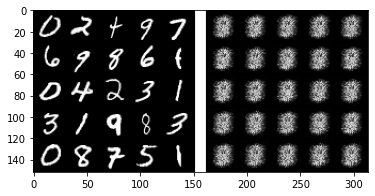

Step 2000: Generator loss: 1.9808058092594116, discriminator loss: 0.17534408741444346


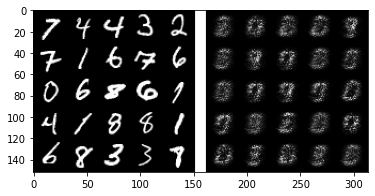

Step 3000: Generator loss: 1.8638581258058566, discriminator loss: 0.1799222729876636


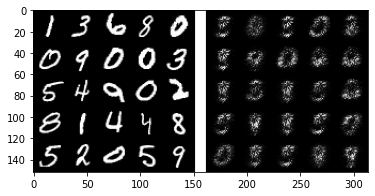

Step 4000: Generator loss: 2.713747075796128, discriminator loss: 0.10277599552273753


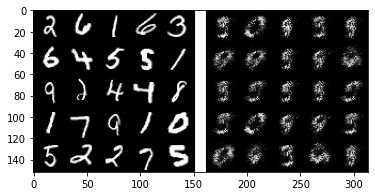

Step 5000: Generator loss: 3.426913810729983, discriminator loss: 0.0805460079610346


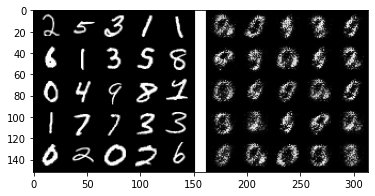

Step 6000: Generator loss: 3.761583680629726, discriminator loss: 0.07324491156637665


Step 7000: Generator loss: 3.841869521856306, discriminator loss: 0.06710284756124023


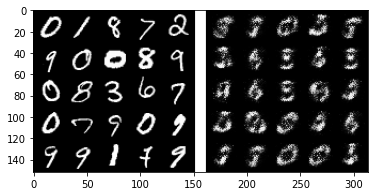

Step 8000: Generator loss: 3.89183938550949, discriminator loss: 0.05877285624295473


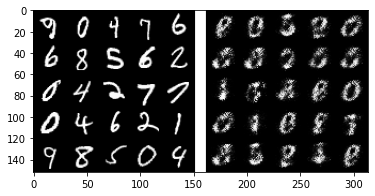

Step 9000: Generator loss: 4.042132008075719, discriminator loss: 0.05387385319732128


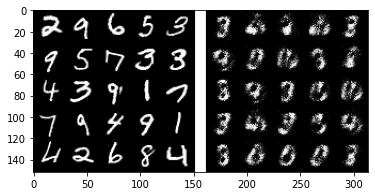

Step 10000: Generator loss: 3.9595198776721983, discriminator loss: 0.06745423914864664


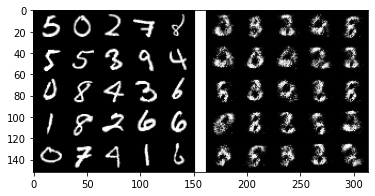

Step 11000: Generator loss: 3.859953703880312, discriminator loss: 0.07884630664810544


Step 12000: Generator loss: 3.8985138311386174, discriminator loss: 0.08377991572767489


Step 13000: Generator loss: 3.8381348071098373, discriminator loss: 0.0950221793688834


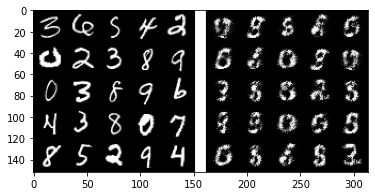

Step 14000: Generator loss: 3.743347091436385, discriminator loss: 0.09010571882687511


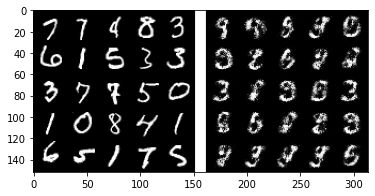

Step 15000: Generator loss: 3.5150490972995723, discriminator loss: 0.11229398793727144


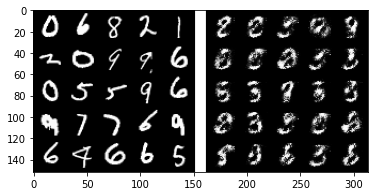

Step 16000: Generator loss: 3.519430354356768, discriminator loss: 0.12421577583998446


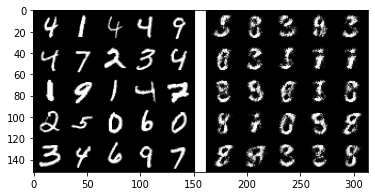

Step 17000: Generator loss: 3.5363320982456243, discriminator loss: 0.11772812987118979


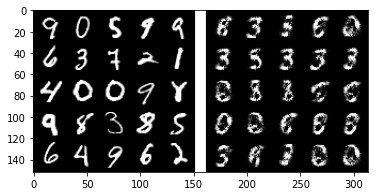

Step 18000: Generator loss: 3.450846367835999, discriminator loss: 0.14400076117366545


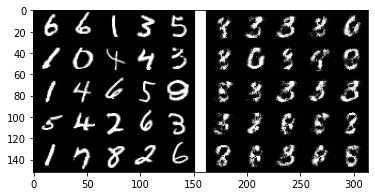

Step 19000: Generator loss: 3.459382193803791, discriminator loss: 0.1399867225810885


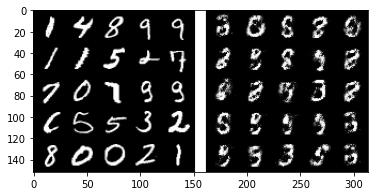

Step 20000: Generator loss: 3.251005339384077, discriminator loss: 0.16067109975218777


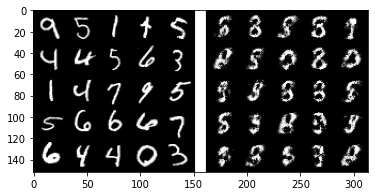

Step 21000: Generator loss: 3.2554472694396988, discriminator loss: 0.15727367828041308


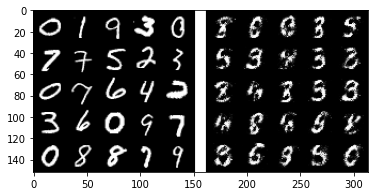

Step 22000: Generator loss: 3.046854007244109, discriminator loss: 0.19086076261848223


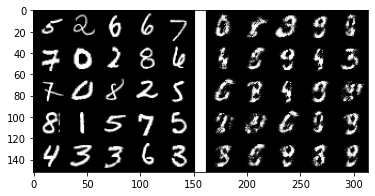

Step 23000: Generator loss: 3.133225337505341, discriminator loss: 0.1737872343212368


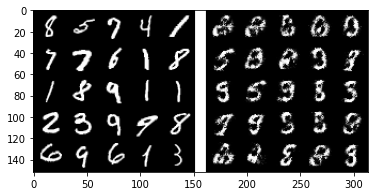

Step 24000: Generator loss: 3.014840875864026, discriminator loss: 0.19785384910553697


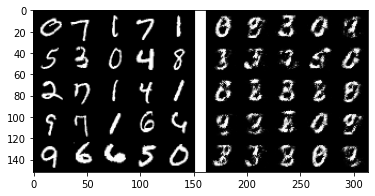

Step 25000: Generator loss: 2.836957906723026, discriminator loss: 0.22134109912812724


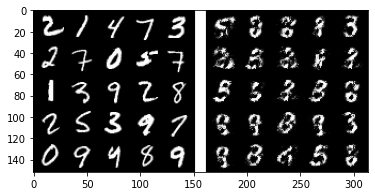

Step 26000: Generator loss: 2.8293388199806255, discriminator loss: 0.21287276686727985


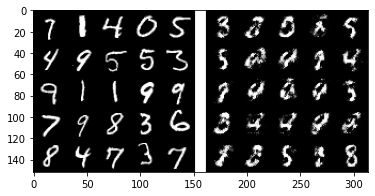

Step 27000: Generator loss: 2.714187621593483, discriminator loss: 0.21617110395431513


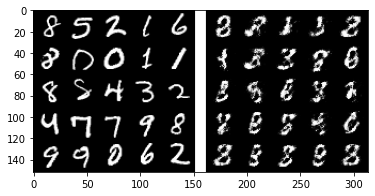

Step 28000: Generator loss: 2.683322758436203, discriminator loss: 0.22824526970088474


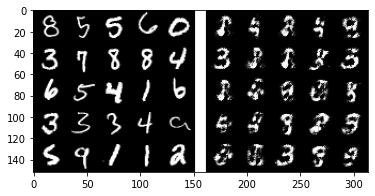

Step 29000: Generator loss: 2.6423344620466227, discriminator loss: 0.22143589405715444


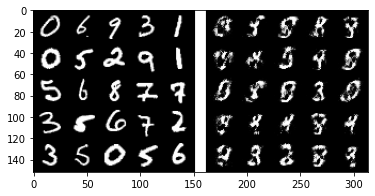

Step 30000: Generator loss: 2.525090405583381, discriminator loss: 0.24487628799676903


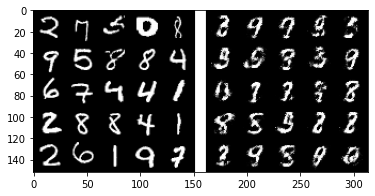

Step 31000: Generator loss: 2.4810053434371935, discriminator loss: 0.2545534577369692


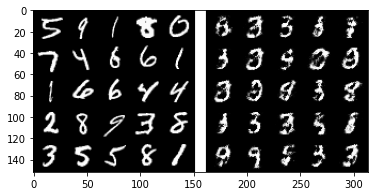

Step 32000: Generator loss: 2.422455093860626, discriminator loss: 0.2541366244703533


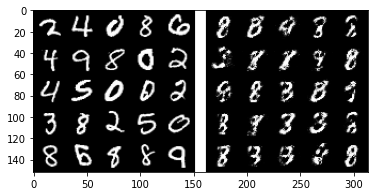

Step 33000: Generator loss: 2.395459025502203, discriminator loss: 0.26144628375768636


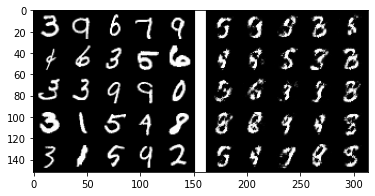

Step 34000: Generator loss: 2.4213243066072465, discriminator loss: 0.26217952750623225


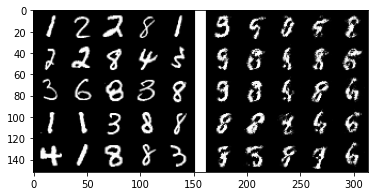

Step 35000: Generator loss: 2.2845643445253385, discriminator loss: 0.28223800276219807


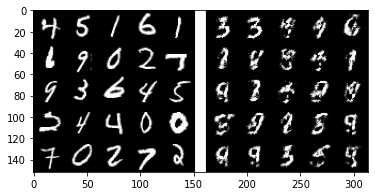

Step 36000: Generator loss: 2.2712595925331134, discriminator loss: 0.28773652416467643


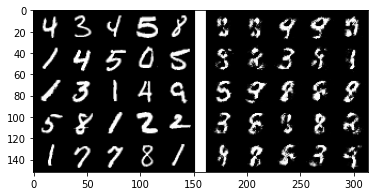

Step 37000: Generator loss: 2.202739691019058, discriminator loss: 0.29269399379193806


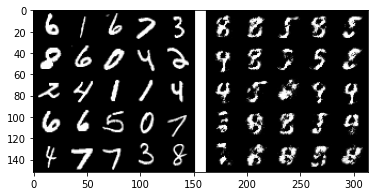

Step 38000: Generator loss: 2.2645821270942696, discriminator loss: 0.2849234950840472


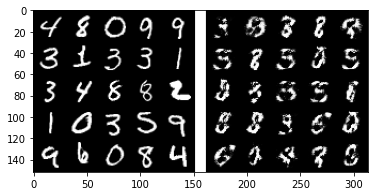

Step 39000: Generator loss: 2.259075294852255, discriminator loss: 0.2921599625051018


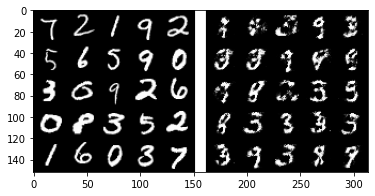

Step 40000: Generator loss: 2.0875956425666815, discriminator loss: 0.3217510928511617


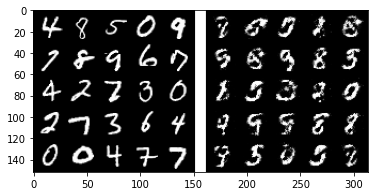

Step 41000: Generator loss: 2.2045479341745406, discriminator loss: 0.28961030067503474


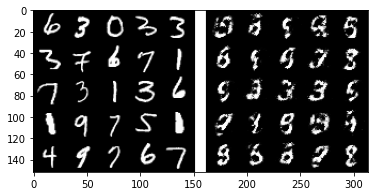

Step 42000: Generator loss: 2.192390137195588, discriminator loss: 0.29698548603057884


Step 43000: Generator loss: 1.977011300325394, discriminator loss: 0.33668023845553335


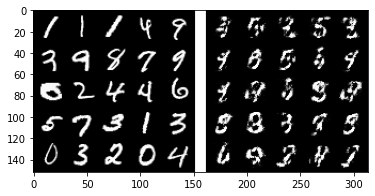

Step 44000: Generator loss: 1.989370196819307, discriminator loss: 0.3267671285420653


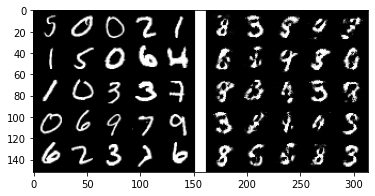

Step 45000: Generator loss: 1.9751773309707654, discriminator loss: 0.33465813888609386


Step 46000: Generator loss: 1.9821088422536828, discriminator loss: 0.33675826168060324


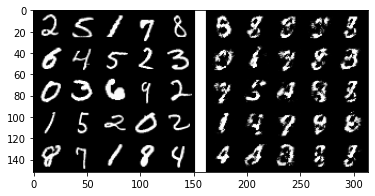

Step 47000: Generator loss: 1.9866681239604953, discriminator loss: 0.3321476569920775


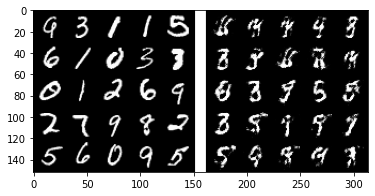

Step 48000: Generator loss: 1.9486071289777749, discriminator loss: 0.34610741098225134


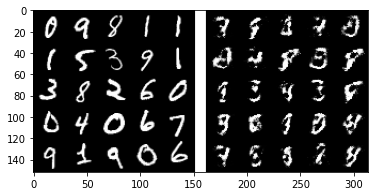

Step 49000: Generator loss: 1.9328960840702052, discriminator loss: 0.34167232139408643


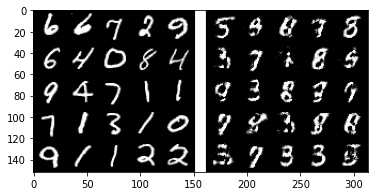

Step 50000: Generator loss: 1.9039753211736665, discriminator loss: 0.34911729602515745


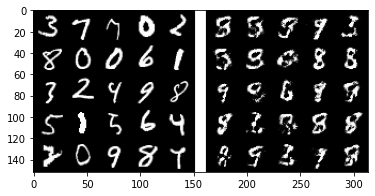

Step 51000: Generator loss: 1.8878795145750078, discriminator loss: 0.34977702233195324


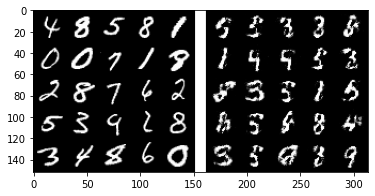

Step 52000: Generator loss: 1.84981496977806, discriminator loss: 0.355275683149696


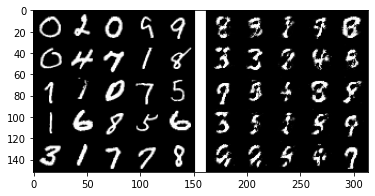

Step 53000: Generator loss: 1.816901520609855, discriminator loss: 0.3651714341044427


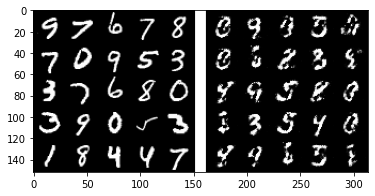

Step 54000: Generator loss: 1.755206284642221, discriminator loss: 0.3785172070860866


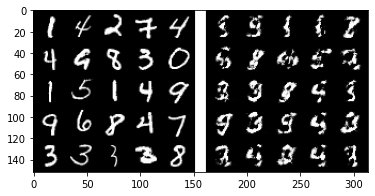

Step 55000: Generator loss: 1.7225625541210172, discriminator loss: 0.3889982451200485


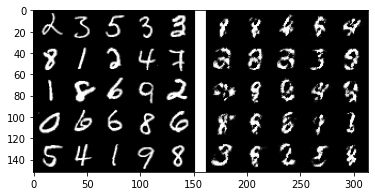

Step 56000: Generator loss: 1.6794697843790074, discriminator loss: 0.4085468159317973


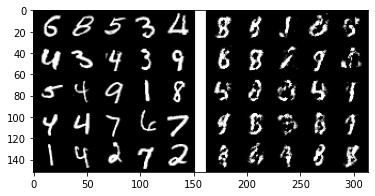

Step 57000: Generator loss: 1.670595208764076, discriminator loss: 0.39861176222562805


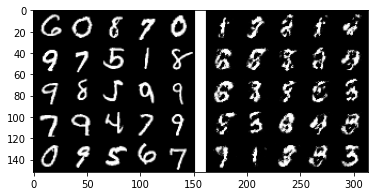

Step 58000: Generator loss: 1.6668527880907056, discriminator loss: 0.39383544278144816


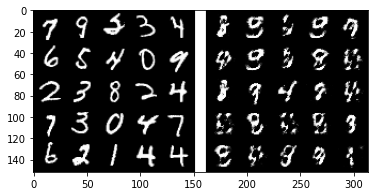

Step 59000: Generator loss: 1.7581382603645328, discriminator loss: 0.3612478258311752


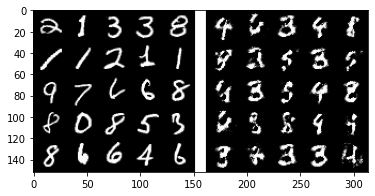

Step 60000: Generator loss: 1.7456871924400335, discriminator loss: 0.36872820731997513


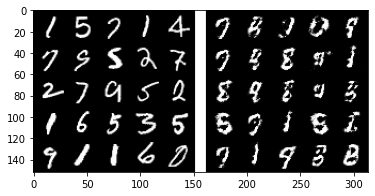

Step 61000: Generator loss: 1.6441504811048522, discriminator loss: 0.388315725505352


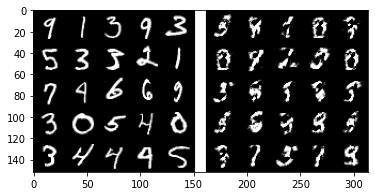

Step 62000: Generator loss: 1.6378066757917387, discriminator loss: 0.3932172485888013


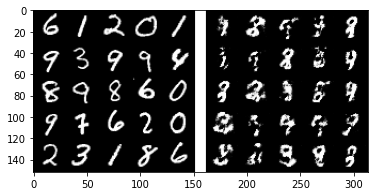

Step 63000: Generator loss: 1.6990121272802352, discriminator loss: 0.3755090998560186


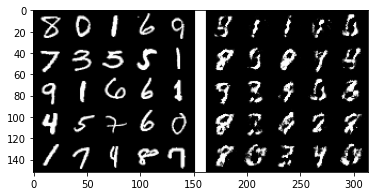

Step 64000: Generator loss: 1.5844377990961083, discriminator loss: 0.409698107898236


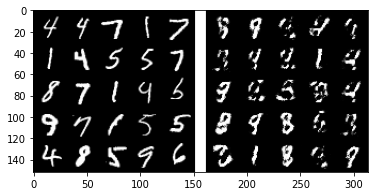

Step 65000: Generator loss: 1.5328121850490561, discriminator loss: 0.4213901071250435


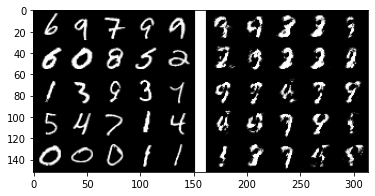

Step 66000: Generator loss: 1.557451537728307, discriminator loss: 0.41985450276732467


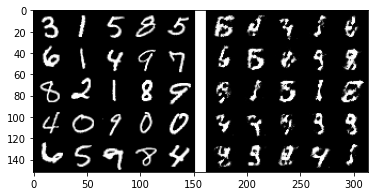

Step 67000: Generator loss: 1.5670425084829342, discriminator loss: 0.41108898872137095


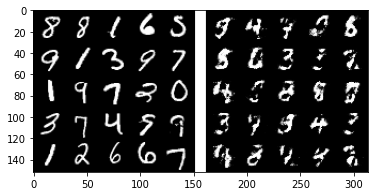

Step 68000: Generator loss: 1.605801216959954, discriminator loss: 0.3922877729535105


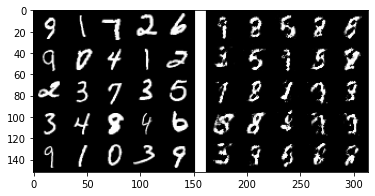

Step 69000: Generator loss: 1.5374847053289415, discriminator loss: 0.4185362601280208


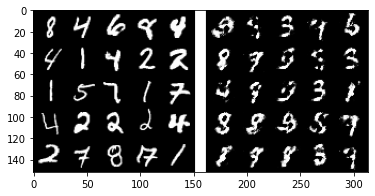

Step 70000: Generator loss: 1.5337381316423395, discriminator loss: 0.41547386312484763


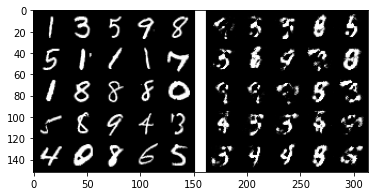

Step 71000: Generator loss: 1.5408837306499494, discriminator loss: 0.41568939366936675


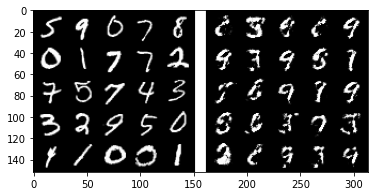

Step 72000: Generator loss: 1.505752033948896, discriminator loss: 0.430282148212195


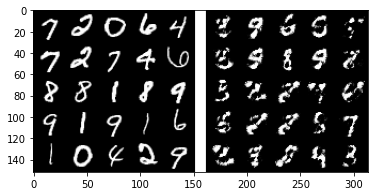

Step 73000: Generator loss: 1.4280400729179386, discriminator loss: 0.44419679370522486


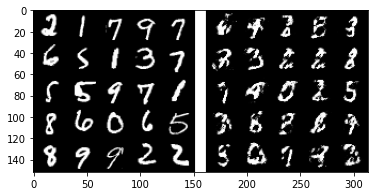

Step 74000: Generator loss: 1.4757918030023602, discriminator loss: 0.4312069092690947


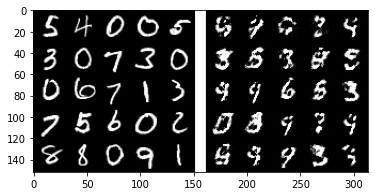

Step 75000: Generator loss: 1.4058160343170159, discriminator loss: 0.4479059619009494


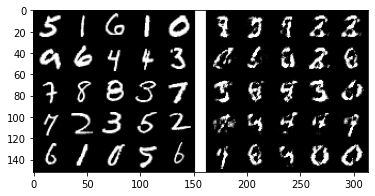

Step 76000: Generator loss: 1.3657707498073572, discriminator loss: 0.4673119792938231


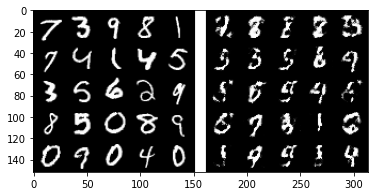

Step 77000: Generator loss: 1.370490192532539, discriminator loss: 0.45976519867777843


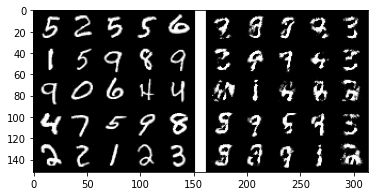

Step 78000: Generator loss: 1.3578252104520803, discriminator loss: 0.4638505289852617


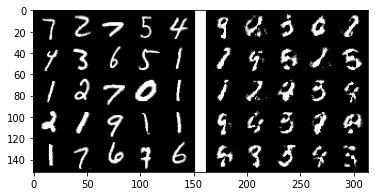

Step 79000: Generator loss: 1.4715622888803457, discriminator loss: 0.4254664987623693


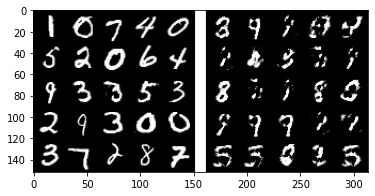

Step 80000: Generator loss: 1.3831443079710004, discriminator loss: 0.44867290472984245


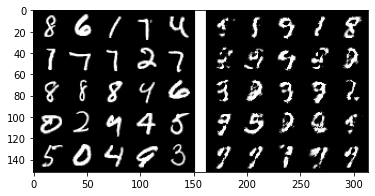

Step 81000: Generator loss: 1.39413252544403, discriminator loss: 0.44663324388861625


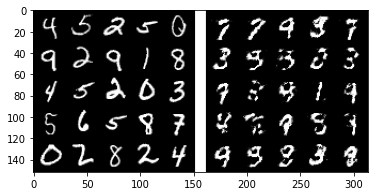

Step 82000: Generator loss: 1.4152564440965636, discriminator loss: 0.44129335030913347


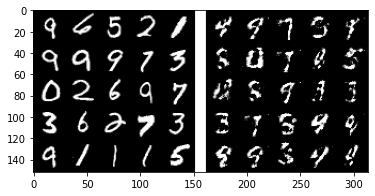

Step 83000: Generator loss: 1.4118124610185614, discriminator loss: 0.4318492962121959


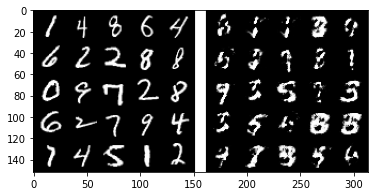

Step 84000: Generator loss: 1.4351327121257789, discriminator loss: 0.42561644029617296


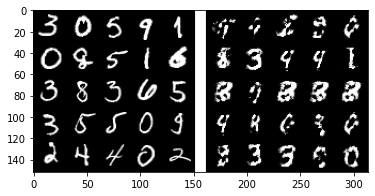

Step 85000: Generator loss: 1.4732788596153261, discriminator loss: 0.41838444072008124


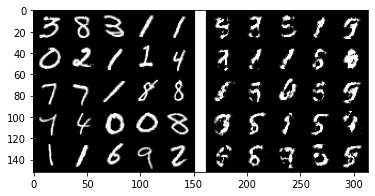

Step 86000: Generator loss: 1.4111704066991813, discriminator loss: 0.44082185161113746


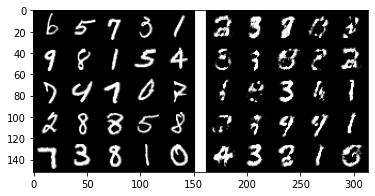

Step 87000: Generator loss: 1.2980201516151415, discriminator loss: 0.4685726262927055


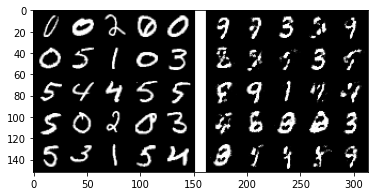

Step 88000: Generator loss: 1.3608321334123614, discriminator loss: 0.45179925528168613


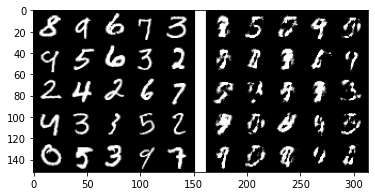

Step 89000: Generator loss: 1.2934664901494977, discriminator loss: 0.4752031669914715


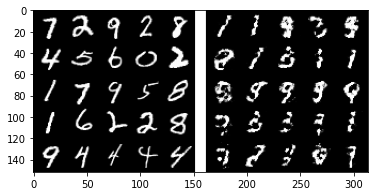

Step 90000: Generator loss: 1.3667279533147791, discriminator loss: 0.44774003753066083


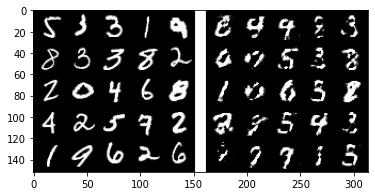

Step 91000: Generator loss: 1.2580814584493623, discriminator loss: 0.4814675730764872


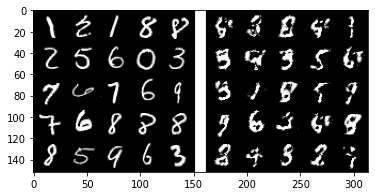

Step 92000: Generator loss: 1.2484648574590704, discriminator loss: 0.49141009369492566


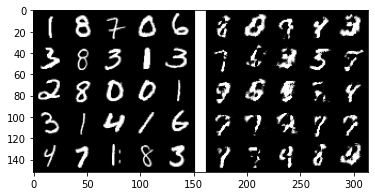

Step 93000: Generator loss: 1.260591948151588, discriminator loss: 0.477101517379284


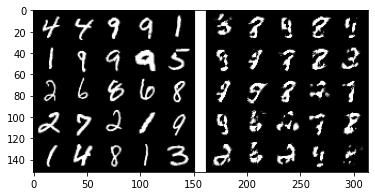

In [62]:
from tqdm.auto import tqdm

cur_step = 0
mean_generator_loss = 0
mean_discriminator_loss = 0
test_generator = True # Whether the generator should be tested
gen_loss = False
error = False


for epoch in range(n_epochs):
  
    # Dataloader returns the batches
    for real, _ in tqdm(dataloader):
        cur_batch_size = len(real)

        # Flatten the batch of real images from the dataset
        real = real.view(cur_batch_size, -1).to(device)

        ### Update discriminator ###

        # Zero out the gradients before backpropagation
        disc_opt.zero_grad()
        disc_loss = get_disc_loss(gen, disc, criterion, real, cur_batch_size, z_dim, device)
        disc_loss.backward(retain_graph=True)
        disc_opt.step()

        # For testing purposes, to keep track of the generator weights
        if test_generator:
            old_generator_weights = gen.gen[0][0].weight.detach().clone()

        ### Update generator ###
        gen_opt.zero_grad()
        gen_loss = get_gen_loss(gen, disc, criterion, cur_batch_size, z_dim, device)
        gen_loss.backward(retain_graph=True)
        gen_opt.step()

        # For testing purposes, to check that your code changes the generator weights
        if test_generator:
            try:
                assert lr > 0.0000002 or (gen.gen[0][0].weight.grad.abs().max() < 0.0005 and epoch == 0)
                assert torch.any(gen.gen[0][0].weight.detach().clone() != old_generator_weights)
            except:
                error = True
                print("Runtime tests have failed")

        # Keep track of the average discriminator loss
        mean_discriminator_loss += disc_loss.item() / display_step

        # Keep track of the average generator loss
        mean_generator_loss += gen_loss.item() / display_step

        ### Visualization code ###
        if cur_step % display_step == 0 and cur_step > 0:
            print(f"Step {cur_step}: Generator loss: {mean_generator_loss}, discriminator loss: {mean_discriminator_loss}")
            fake_noise = get_noise(cur_batch_size, z_dim, device=device)
            fake = gen(fake_noise)
            show_tensor_images(real, fake)
            mean_generator_loss = 0
            mean_discriminator_loss = 0
        cur_step += 1